In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Mato Grosso Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_MS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso Do Sul - Consumo de Cimento (t),Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Educacao,Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,33.744,10575.832000,3.127511,951.776390,1411.785524,24.741737,18.860002,72.032926,3.117091,0.741626,53.166560,0.670882,0.795565,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07,1.583944e+06,0.781096,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,32.230,10674.618538,3.124972,952.492950,1417.150685,24.087997,17.858746,70.442692,3.134253,0.741710,53.245714,0.671146,0.795878,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07,1.591665e+06,0.780750,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,33.559,10766.098168,2.985641,953.076971,1387.889369,23.538968,16.806765,68.403583,3.225807,0.741794,52.994640,0.671410,0.796192,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07,1.599385e+06,0.780403,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,34.283,10853.134597,2.615077,953.978721,1365.688397,22.897246,15.218196,64.880324,3.365984,0.741878,53.019283,0.671673,0.796506,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07,1.607106e+06,0.780057,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,36.066,10952.713907,2.488609,954.723605,1361.257638,22.059134,13.316197,61.056254,3.546947,0.741962,53.539593,0.671937,0.796820,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07,1.614826e+06,0.779710,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2002-8,NaN,NaN,2.658799,953.010197,1389.843663,24.164653,14.249012,57.849305,4.247241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2002-9,NaN,NaN,2.641716,952.337589,1442.950201,24.585985,15.370194,59.903115,4.169688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,2002-10,NaN,NaN,2.858744,951.610669,1450.895260,25.150173,17.022021,63.836608,3.862138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2002-11,NaN,NaN,2.964151,951.513490,1468.604568,25.132801,17.963946,67.311116,3.498752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


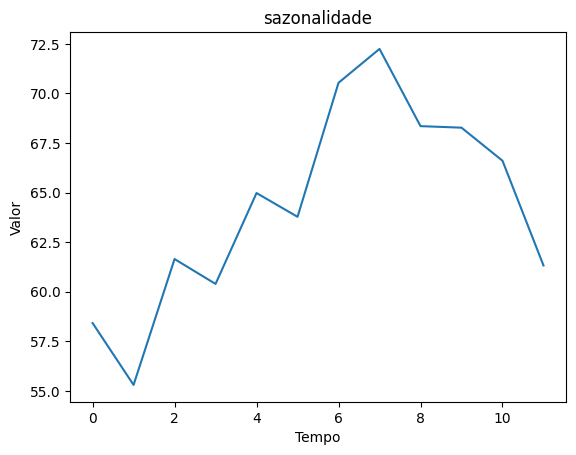

,sazonalidade
sazonalidade,
0,58.417627
1,55.295934
2,61.645365
3,60.389631
4,64.974568
5,63.774721
6,70.536006
7,72.243512
8,68.349403


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Educacao,Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Mato Grosso Do Sul - Consumo de Cimento (t)
0,2003-1,10575.832000,3.127511,951.776390,1411.785524,24.741737,18.860002,72.032926,3.117091,0.741626,53.166560,0.670882,0.795565,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07,1.583944e+06,0.781096,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,58.417627,33.744
1,2003-2,10674.618538,3.124972,952.492950,1417.150685,24.087997,17.858746,70.442692,3.134253,0.741710,53.245714,0.671146,0.795878,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07,1.591665e+06,0.780750,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,55.295934,32.230
2,2003-3,10766.098168,2.985641,953.076971,1387.889369,23.538968,16.806765,68.403583,3.225807,0.741794,52.994640,0.671410,0.796192,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07,1.599385e+06,0.780403,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,61.645365,33.559
3,2003-4,10853.134597,2.615077,953.978721,1365.688397,22.897246,15.218196,64.880324,3.365984,0.741878,53.019283,0.671673,0.796506,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07,1.607106e+06,0.780057,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,60.389631,34.283
4,2003-5,10952.713907,2.488609,954.723605,1361.257638,22.059134,13.316197,61.056254,3.546947,0.741962,53.539593,0.671937,0.796820,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07,1.614826e+06,0.779710,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,64.974568,36.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2002-8,NaN,2.658799,953.010197,1389.843663,24.164653,14.249012,57.849305,4.247241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.974568,NaN
257,2002-9,NaN,2.641716,952.337589,1442.950201,24.585985,15.370194,59.903115,4.169688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.774721,NaN
258,2002-10,NaN,2.858744,951.610669,1450.895260,25.150173,17.022021,63.836608,3.862138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.536006,NaN
259,2002-11,NaN,2.964151,951.513490,1468.604568,25.132801,17.963946,67.311116,3.498752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
256       NaN
257       NaN
258       NaN
259       NaN
260       NaN
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 261, dtype: float64

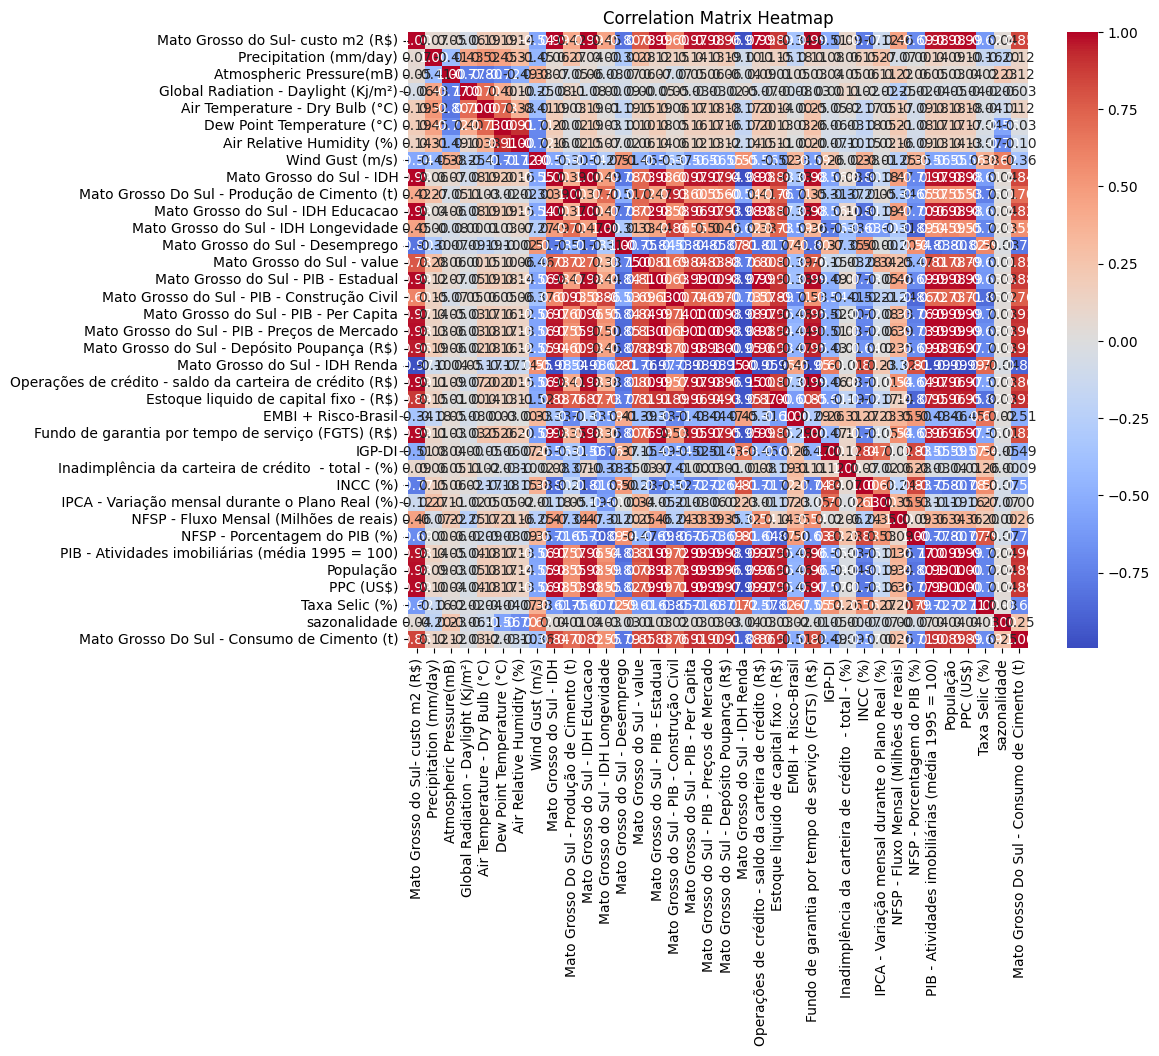

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Mato Grosso do Sul- custo m2 (R$),3.371174e+06
1,Precipitation (mm/day),5.923230e+00
2,Atmospheric Pressure(mB),3.288299e+01
3,Global Radiation - Daylight (Kj/m²),9.840096e+00
4,Air Temperature - Dry Bulb (°C),1.677105e+02
5,Dew Point Temperature (°C),8.048414e+02
6,Air Relative Humidity (%),4.638527e+02
7,Wind Gust (m/s),2.342314e+01
8,Mato Grosso do Sul - IDH,1.334588e+09
9,Mato Grosso Do Sul - Produção de Cimento (t),1.890266e+03


In [40]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,10575.832000,3.127511,951.776390,1411.785524,24.741737,18.860002,72.032926,3.117091,53.166560,0.795565,8.248824,0.282837,4.562945e+07,2.151917e+06,1.583944e+06,0.781096,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,58.417627
1,10674.618538,3.124972,952.492950,1417.150685,24.087997,17.858746,70.442692,3.134253,53.245714,0.795878,8.242935,0.284487,4.568706e+07,2.153542e+06,1.591665e+06,0.780750,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,55.295934
2,10766.098168,2.985641,953.076971,1387.889369,23.538968,16.806765,68.403583,3.225807,52.994640,0.796192,8.237046,0.285379,4.574467e+07,2.155168e+06,1.599385e+06,0.780403,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,61.645365
3,10853.134597,2.615077,953.978721,1365.688397,22.897246,15.218196,64.880324,3.365984,53.019283,0.796506,8.231157,0.286089,4.580228e+07,2.156794e+06,1.607106e+06,0.780057,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,60.389631
4,10952.713907,2.488609,954.723605,1361.257638,22.059134,13.316197,61.056254,3.546947,53.539593,0.796820,8.225268,0.286122,4.585990e+07,2.158419e+06,1.614826e+06,0.779710,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,64.974568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,24007.118209,2.510301,952.551550,1442.975247,24.304158,14.404170,58.550079,3.490772,57.090845,0.804922,6.953989,0.311653,5.673072e+07,2.235269e+06,3.553957e+06,0.744107,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,72.243512
176,24085.631133,2.820743,951.986193,1456.026786,24.681670,15.398085,60.804930,3.303352,56.907334,0.804626,6.945585,0.311775,5.672868e+07,2.235028e+06,3.569945e+06,0.744129,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,68.349403
177,24163.080700,2.738909,951.408949,1427.099189,24.495922,16.917381,66.296116,3.091997,56.749771,0.804331,6.937182,0.311905,5.672665e+07,2.234787e+06,3.585932e+06,0.744152,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,68.271692
178,24238.999879,2.704049,951.134544,1416.332723,24.552974,17.726309,69.045518,2.894932,56.951568,0.804035,6.928778,0.312127,5.672461e+07,2.234546e+06,3.601919e+06,0.744174,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.

In [41]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,1.261174,-0.779055,0.136459,1.138822,1.399672,1.180769,-0.537925,-1.478264,-3.084033,1.157071,-0.425321,-1.585377,-2.352195,-1.447053,2.059474,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.206473
1,1.254977,-0.204199,0.207375,0.481405,0.901976,0.864829,-0.492099,-1.469741,-2.993259,1.146571,-0.389043,-1.570153,-2.311623,-1.436722,2.028066,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.844710
2,0.915028,0.264328,-0.179396,-0.070712,0.379066,0.459709,-0.247622,-1.496777,-2.902484,1.136070,-0.369434,-1.554929,-2.271050,-1.426392,1.996658,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.546555
3,0.010898,0.987752,-0.472845,-0.716043,-0.410567,-0.240275,0.126694,-1.494124,-2.811709,1.125570,-0.353836,-1.539705,-2.230477,-1.416061,1.965249,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.803293
4,-0.297668,1.585331,-0.531410,-1.558870,-1.355996,-1.000023,0.609918,-1.438095,-2.720934,1.115069,-0.353108,-1.524481,-2.189905,-1.405730,1.933841,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.134108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.244741,-0.157187,0.548719,0.698782,-0.815196,-1.497938,0.459914,-1.055682,-0.377743,-1.151702,0.208020,1.348192,-0.271957,1.188994,-1.293086,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.620260
176,0.512698,-0.610741,0.721232,1.078417,-0.321149,-1.049955,-0.040554,-1.075443,-0.463216,-1.166686,0.210697,1.347655,-0.277971,1.210387,-1.291060,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,0.824100
177,0.313034,-1.073832,0.338872,0.891625,0.434050,0.041007,-0.604935,-1.092410,-0.548688,-1.181670,0.213544,1.347117,-0.283986,1.231779,-1.289034,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,0.808212
178,0.227980,-1.293972,0.196563,0.948997,0.836145,0.587245,-1.131157,-1.070680,-0.634160,-1.196654,0.218421,1.346579,-0.290000,1.253171,-1.287008,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,0.467147


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,1.261174,-0.779055,0.136459,1.138822,1.399672,1.180769,-0.537925,-1.478264,-3.084033,1.157071,-0.425321,-1.585377,-2.352195,-1.447053,2.059474,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.206473
1,1.254977,-0.204199,0.207375,0.481405,0.901976,0.864829,-0.492099,-1.469741,-2.993259,1.146571,-0.389043,-1.570153,-2.311623,-1.436722,2.028066,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.844710
2,0.915028,0.264328,-0.179396,-0.070712,0.379066,0.459709,-0.247622,-1.496777,-2.902484,1.136070,-0.369434,-1.554929,-2.271050,-1.426392,1.996658,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.546555
3,0.010898,0.987752,-0.472845,-0.716043,-0.410567,-0.240275,0.126694,-1.494124,-2.811709,1.125570,-0.353836,-1.539705,-2.230477,-1.416061,1.965249,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.803293
4,-0.297668,1.585331,-0.531410,-1.558870,-1.355996,-1.000023,0.609918,-1.438095,-2.720934,1.115069,-0.353108,-1.524481,-2.189905,-1.405730,1.933841,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.134108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-1.492076,1.038992,-0.007052,-0.373259,-0.160587,-0.329241,0.091985,-0.642098,0.572141,-0.808997,0.372463,1.332398,-0.076793,0.947453,-1.363761,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.620260
164,-1.385901,0.470395,0.396306,0.091437,0.397070,0.195856,-0.093382,-0.693027,0.501825,-0.856561,0.341829,1.336310,-0.107406,0.965812,-1.352462,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,0.824100
165,-0.742822,-0.202954,0.618023,0.623876,1.014668,0.797754,-0.528466,-0.757685,0.431510,-0.904124,0.316474,1.340222,-0.138018,0.984171,-1.341164,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,0.808212
166,-0.753601,-0.403988,0.749299,0.911210,1.355494,1.165346,-1.105809,-0.805380,0.361194,-0.951687,0.295600,1.344134,-0.168630,1.002531,-1.329865,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,0.467147


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
163    87.863
164    69.723
165    72.765
166    77.937
167    64.332
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 30)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,0.017840,-0.546030,0.755026,0.910320,1.213722,1.088726,-1.455400,0.933936,-0.096514,-0.931772,1.306283,1.006755,0.764400,1.374121,-0.747893,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,-1.206473
133,0.059938,-0.308237,-0.176833,0.396557,1.032805,1.181066,-1.291642,0.931654,-0.148947,-0.890133,1.308629,1.020757,0.743647,1.349885,-0.738374,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,-1.844710
134,-0.038509,0.261707,-1.061731,-0.280703,0.766938,1.246258,-1.053508,0.894757,-0.201380,-0.848494,1.309562,1.034759,0.722894,1.325649,-0.728856,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,-0.546555
135,-0.340755,1.047578,-1.903393,-1.030492,0.233295,0.980855,-0.570022,0.857122,-0.253813,-0.806856,1.313523,1.048761,0.702141,1.301413,-0.719338,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,-0.803293
136,-0.468955,1.533329,-1.996057,-1.405499,-0.444675,0.290517,-0.212310,0.819143,-0.306246,-0.765217,1.313398,1.062764,0.681388,1.277177,-0.709820,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,0.134108
137,-0.967785,1.556819,-1.584379,-0.931251,-0.650259,-0.309632,0.129483,0.780583,-0.358678,-0.723579,1.312874,1.076766,0.660635,1.252941,-0.700301,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,-0.111203
138,-1.242549,1.376975,-0.567241,-0.122816,-0.876131,-1.098497,0.405375,0.741873,-0.411111,-0.681940,1.304768,1.090768,0.639882,1.228705,-0.690783,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,1.271156
139,-0.766886,0.664280,0.276528,0.616779,-0.647588,-1.244385,0.229127,0.702201,-0.463544,-0.640302,1.293312,1.104770,0.619129,1.204469,-0.681265,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,1.620260
140,-0.382306,-0.038000,0.421691,1.093091,-0.000738,-0.624856,-0.066311,0.662172,-0.515977,-0.598663,1.276554,1.118773,0.598376,1.180233,-0.671747,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,0.824100
141,0.714526,-0.218098,0.925203,1.375573,0.430216,-0.211800,-0.537070,0.622061,-0.568410,-0.557024,1.255749,1.132775,0.577623,1.155997,-0.662228,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,0.808212


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[1790520092, 2793232551, 2035019277, 1127401408, 163205550, 2765883089, 3856417351, 2123263416, 4100954943, 1629915621]


Step: 0 ___________________________________________
val_loss: 42.226890563964844
winner_seed: 1790520092


Step: 1 ___________________________________________
val_loss: 35.035823822021484
winner_seed: 2793232551


Step: 2 ___________________________________________
val_loss: 42.96539306640625


Step: 3 ___________________________________________
val_loss: 33.301753997802734
winner_seed: 1127401408


Step: 4 ___________________________________________
val_loss: 43.296268463134766


Step: 5 ___________________________________________
val_loss: 44.070682525634766


Step: 6 ___________________________________________
val_loss: 27.01345443725586
winner_seed: 3856417351


Step: 7 ___________________________________________
val_loss: 45.34284591674805


Step: 8 ___________________________________________
val_loss: 40.37458801269531


Step: 9 _______________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,62.964249,65.268425,66.310638,68.352036,71.590309,76.439003,81.715202,82.462639,79.412193,74.832619,73.343269,69.646454
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,14.083748,0.391579,0.865639,9.742966,9.407692,7.024002,5.630798,0.425362,0.125191,7.022385,4.151733,13.034454


[1258700917, 1178688351, 3425927932, 1920645311, 3969094892, 1376175592, 1855327192, 800128457, 1356270288, 1567090104]


Step: 0 ___________________________________________
val_loss: 44.018436431884766
winner_seed: 1258700917


Step: 1 ___________________________________________
val_loss: 39.64959716796875
winner_seed: 1178688351


Step: 2 ___________________________________________
val_loss: 45.390193939208984


Step: 3 ___________________________________________
val_loss: 41.9384651184082


Step: 4 ___________________________________________
val_loss: 45.45967483520508


Step: 5 ___________________________________________
val_loss: 39.71072006225586


Step: 6 ___________________________________________
val_loss: 53.42322540283203


Step: 7 ___________________________________________
val_loss: 38.90578842163086
winner_seed: 800128457


Step: 8 ___________________________________________
val_loss: 54.80067825317383


Step: 9 ___________________________________________
val_loss: 35.762

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.152275,65.714897,66.427368,65.915977,69.786766,75.281235,83.459892,84.844803,81.378311,76.167404,72.068993,67.710701
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,11.895721,0.054893,0.982368,12.179024,11.211235,5.866234,3.886108,1.956802,2.091309,5.687599,5.42601,11.098701


[3502170206, 689404794, 2596529347, 663428281, 438841835, 3278302490, 3836961183, 1081042232, 695253280, 302338706]


Step: 0 ___________________________________________
val_loss: 32.960594177246094
winner_seed: 3502170206


Step: 1 ___________________________________________
val_loss: 40.66625213623047


Step: 2 ___________________________________________
val_loss: 41.97178268432617


Step: 3 ___________________________________________
val_loss: 48.3753662109375


Step: 4 ___________________________________________
val_loss: 48.510047912597656


Step: 5 ___________________________________________
val_loss: 40.88987731933594


Step: 6 ___________________________________________
val_loss: 44.814029693603516


Step: 7 ___________________________________________
val_loss: 44.98216247558594


Step: 8 ___________________________________________
val_loss: 39.54127883911133


Step: 9 ___________________________________________
val_loss: 51.9401969909668
1/1 [==============================] - 

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,60.382603,64.841461,65.930023,66.828819,72.944244,78.202209,81.860413,81.536713,78.183548,75.715042,74.02533,71.155197
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,16.665394,0.818542,0.485023,11.266182,8.053757,8.787209,5.485588,1.351288,1.103455,6.139961,3.469673,14.543198


[2097022414, 1793070142, 3977049026, 3783465905, 4211301530, 2160673957, 880792270, 201866346, 331369141, 2903900274]


Step: 0 ___________________________________________
val_loss: 44.183013916015625
winner_seed: 2097022414


Step: 1 ___________________________________________
val_loss: 34.480873107910156
winner_seed: 1793070142


Step: 2 ___________________________________________
val_loss: 38.60558319091797


Step: 3 ___________________________________________
val_loss: 38.544212341308594


Step: 4 ___________________________________________
val_loss: 60.714599609375


Step: 5 ___________________________________________
val_loss: 35.04966354370117


Step: 6 ___________________________________________
val_loss: 37.85713577270508


Step: 7 ___________________________________________
val_loss: 55.88373947143555


Step: 8 ___________________________________________
val_loss: 41.98246383666992


Step: 9 ___________________________________________
val_loss: 36.28425598144531
1/1 [========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.022858,63.982018,68.357285,66.562859,72.071831,74.441467,84.402885,81.239075,78.096283,75.280067,72.476669,60.772251
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,12.025139,1.677986,2.912285,11.532143,8.92617,5.026466,2.943115,1.648926,1.19072,6.574936,5.018333,4.160252


[1767173088, 1637583224, 818491185, 2223455399, 1742830951, 1569451504, 2625148299, 3622039860, 323443535, 3617840638]


Step: 0 ___________________________________________
val_loss: 41.34967803955078
winner_seed: 1767173088


Step: 1 ___________________________________________
val_loss: 39.05299758911133
winner_seed: 1637583224


Step: 2 ___________________________________________
val_loss: 42.218231201171875


Step: 3 ___________________________________________
val_loss: 46.67475128173828


Step: 4 ___________________________________________
val_loss: 30.139389038085938
winner_seed: 1742830951


Step: 5 ___________________________________________
val_loss: 56.188575744628906


Step: 6 ___________________________________________
val_loss: 47.21556854248047


Step: 7 ___________________________________________
val_loss: 49.93522644042969


Step: 8 ___________________________________________
val_loss: 32.93124008178711


Step: 9 ___________________________________________
val_loss: 42.4

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.372841,67.131912,68.103729,68.188141,70.818741,73.545349,78.912148,76.154671,74.58252,74.013344,73.111351,69.105728
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,11.675156,1.471909,2.65873,9.90686,10.17926,4.130348,8.433853,6.73333,4.704483,7.84166,4.383652,12.493729


[4266190718, 659905135, 650714873, 717886224, 2461879959, 656534325, 696042513, 2324699458, 2369799644, 4242223546]


Step: 0 ___________________________________________
val_loss: 41.94733810424805
winner_seed: 4266190718


Step: 1 ___________________________________________
val_loss: 34.923858642578125
winner_seed: 659905135


Step: 2 ___________________________________________
val_loss: 46.24673080444336


Step: 3 ___________________________________________
val_loss: 43.12528991699219


Step: 4 ___________________________________________
val_loss: 33.93325424194336
winner_seed: 2461879959


Step: 5 ___________________________________________
val_loss: 31.485803604125977
winner_seed: 656534325


Step: 6 ___________________________________________
val_loss: 38.394107818603516


Step: 7 ___________________________________________
val_loss: 41.957035064697266


Step: 8 ___________________________________________
val_loss: 37.91878890991211


Step: 9 ______________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,67.587013,64.728149,67.127449,67.886452,74.281418,83.308861,87.973686,84.393723,82.526588,80.233131,77.774666,71.136375
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,9.460983,0.931854,1.682449,10.208549,6.716583,13.89386,0.627686,1.505722,3.239586,1.621872,0.279663,14.524376


[128000860, 1780337304, 395272738, 3560902215, 376896894, 2149868207, 3113137125, 3693996248, 2237453462, 1030978504]


Step: 0 ___________________________________________
val_loss: 31.908992767333984
winner_seed: 128000860


Step: 1 ___________________________________________
val_loss: 33.4150505065918


Step: 2 ___________________________________________
val_loss: 40.42218017578125


Step: 3 ___________________________________________
val_loss: 43.03606033325195


Step: 4 ___________________________________________
val_loss: 44.04246520996094


Step: 5 ___________________________________________
val_loss: 35.5557746887207


Step: 6 ___________________________________________
val_loss: 49.23835372924805


Step: 7 ___________________________________________
val_loss: 37.358089447021484


Step: 8 ___________________________________________
val_loss: 41.4541015625


Step: 9 ___________________________________________
val_loss: 42.96345901489258
1/1 [==============================] - 0s 1

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,61.501244,64.760216,65.380684,65.507385,72.320839,74.246269,81.191093,80.057747,78.42778,75.093643,74.17878,69.785667
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,15.546753,0.899788,0.064316,12.587616,8.677162,4.831268,6.154907,2.830254,0.859222,6.76136,3.316223,13.173668


[1933192979, 367062838, 3347480881, 922434370, 3193907107, 3639570142, 2514297197, 1409050828, 3238704222, 3110301515]


Step: 0 ___________________________________________
val_loss: 42.87727355957031
winner_seed: 1933192979


Step: 1 ___________________________________________
val_loss: 48.25558853149414


Step: 2 ___________________________________________
val_loss: 36.9335823059082
winner_seed: 3347480881


Step: 3 ___________________________________________
val_loss: 37.21739959716797


Step: 4 ___________________________________________
val_loss: 38.73859405517578


Step: 5 ___________________________________________
val_loss: 42.247467041015625


Step: 6 ___________________________________________
val_loss: 45.97140884399414


Step: 7 ___________________________________________
val_loss: 35.930641174316406
winner_seed: 1409050828


Step: 8 ___________________________________________
val_loss: 51.52001190185547


Step: 9 ___________________________________________
val_loss: 39.722

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.220032,66.142944,66.988945,67.844398,73.751976,80.538742,86.786919,84.202049,79.448753,76.534248,73.767456,68.321815
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,11.827965,0.482941,1.543945,10.250603,7.246025,11.123741,0.559082,1.314049,0.161751,5.320755,3.727547,11.709816


[379118359, 1802342734, 3087140604, 3503965805, 964749348, 1447289386, 3797138990, 3671570522, 3401053966, 2606866473]


Step: 0 ___________________________________________
val_loss: 38.61954116821289
winner_seed: 379118359


Step: 1 ___________________________________________
val_loss: 35.19530487060547
winner_seed: 1802342734


Step: 2 ___________________________________________
val_loss: 51.10336685180664


Step: 3 ___________________________________________
val_loss: 40.31486129760742


Step: 4 ___________________________________________
val_loss: 43.77871322631836


Step: 5 ___________________________________________
val_loss: 34.25040817260742
winner_seed: 1447289386


Step: 6 ___________________________________________
val_loss: 49.17612838745117


Step: 7 ___________________________________________
val_loss: 42.02149200439453


Step: 8 ___________________________________________
val_loss: 37.56458282470703


Step: 9 ___________________________________________
val_loss: 44.35035

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,64.978767,64.348083,69.037491,69.044678,72.13028,76.89502,85.814934,84.852303,80.896553,78.846893,76.833794,73.501251
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,12.069229,1.31192,3.592491,9.050323,8.867722,7.480019,1.531067,1.964302,1.60955,3.00811,0.661209,16.889252


[542497427, 2213758235, 2586593015, 1501695793, 2724651369, 2266950198, 1035921717, 640600872, 424530455, 2732108706]


Step: 0 ___________________________________________
val_loss: 39.840576171875
winner_seed: 542497427


Step: 1 ___________________________________________
val_loss: 31.32086753845215
winner_seed: 2213758235


Step: 2 ___________________________________________
val_loss: 68.41300201416016


Step: 3 ___________________________________________
val_loss: 38.965091705322266


Step: 4 ___________________________________________
val_loss: 41.31252670288086


Step: 5 ___________________________________________
val_loss: 39.808837890625


Step: 6 ___________________________________________
val_loss: 45.36708068847656


Step: 7 ___________________________________________
val_loss: 33.432777404785156


Step: 8 ___________________________________________
val_loss: 37.64078140258789


Step: 9 ___________________________________________
val_loss: 46.50519561767578
1/1 [============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.331284,65.804451,68.097557,67.751251,71.118256,77.20932,83.349037,79.564362,78.660233,76.821289,74.41082,69.438873
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,11.716713,0.144447,2.652557,10.34375,9.879745,7.794319,3.996964,3.323639,0.62677,5.033714,3.084183,12.826874


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,64.351318,65.272263,67.176109,67.388199,72.081467,77.010757,83.546623,81.930801,79.16127,76.353775,74.199112,69.057434
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,12.696682,0.387737,1.731109,10.706801,8.916533,7.595757,3.799377,0.957199,0.12573,5.501225,3.295888,12.445434


In [53]:
display(mae)
display(mape)

73.12742

0.07833006185804113